# Environment

In [ ]:
!pip install -q -U --force-reinstall kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/synthetic-word-ocr
!mkdir dataset_satellite
!unzip -qq synthetic-word-ocr.zip -d dataset_satellite

100% 3.92G/3.93G [01:09<00:00, 89.7MB/s]
100% 3.93G/3.93G [01:09<00:00, 60.8MB/s]


In [ ]:
!pip install -U -q segmentation-models
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


# Imports

In [ ]:
import numpy
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np
import cv2

from matplotlib.path import Path
from skimage.color import label2rgb
from sklearn.model_selection import train_test_split
from skimage.util import montage
from keras import models, layers
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import keras
import segmentation_models as sm
from time import time
from segmentation_models.utils import set_trainable
import tensorflow as tf
from datetime import datetime
import io

Segmentation Models: using `tf.keras` framework.


# Constants

In [ ]:
MAP_BASE_DIR = '/content/dataset_satellite'
MAP_IMG_DIR = '/content/dataset_satellite/train/images'
ROOT_PATH_WEIGHTS = '/content/drive/MyDrive/my_ml_projects'
MODEL_WEIGHTS_DIR = 'unet+resnet34'

TEST_SIZE = 0.25
BACKBONE = 'resnet34'
SEED = 7
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 48
CLASSES = 1
IMG_SIZE = 256

PATH_TO_CURRENT_MODEL = os.path.join(ROOT_PATH_WEIGHTS, MODEL_WEIGHTS_DIR)
if not os.path.exists(PATH_TO_CURRENT_MODEL):
    os.mkdir(PATH_TO_CURRENT_MODEL)

# Load dataset

In [ ]:
json_path = os.path.join(MAP_BASE_DIR, 'annotation.json')
with open(json_path, 'r') as f:
    annot_data = json.load(f)

In [ ]:
annot_df = pd.DataFrame(annot_data['annotations'])
image_df = pd.DataFrame(annot_data['images'])
full_df = pd.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id')[['image_id', 'segmentation', 'file_name']].dropna()
print(image_df.shape[0], '+', annot_df.shape[0], '->', full_df.shape[0])

280741 + 2395553 -> 2395553


In [ ]:
%reset_selective -f annot_data
%reset_selective -f annot_df

## DF data research

In [ ]:
annot_df.head(5)

,id,image_id,segmentation,area,bbox,category_id,iscrowd
0,460757,54062,"[[300, 182, 297, 182, 296, 153, 300, 153, 300,...",101.0,"[182, 296, 118, 4]",100,0
1,266461,31255,"[[19.0, 234.0, 19.0, 245.0, 0.0, 246.0, 0.0, 2...",218.0,"[0.0, 0.0, 245.0, 19.0]",100,0
2,313854,36754,"[[133.0, 42.0, 133.0, 4.000000000000001, 197.0...",2432.0,"[4.000000000000001, 133.0, 193.0, 64.0]",100,0
3,278729,32649,"[[125.0, 247.0, 125.0, 300.0, 37.0, 300.0, 36....",4647.0,"[37.0, 36.0, 263.0, 89.0]",100,0
4,509969,59769,"[[200.0, 300.0, 212.0, 280.0, 227.0, 293.0, 23...",4122.0,"[200.0, 200.0, 100.0, 92.0]",100,0


In [ ]:
print(annot_df.info())
annot_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2395553 entries, 0 to 2395552
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   image_id      int64  
 2   segmentation  object 
 3   area          float64
 4   bbox          object 
 5   category_id   int64  
 6   iscrowd       int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 127.9+ MB
None


,id,image_id,area,category_id,iscrowd
count,2.395553e+06,2.395553e+06,2.395553e+06,2395553.0,2395553.0
mean,1.197776e+06,1.404963e+05,2.344715e+03,100.0,0.0
std,6.915367e+05,8.107243e+04,4.103724e+03,0.0,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,100.0,0.0
25%,5.988880e+05,7.027400e+04,4.410000e+02,100.0,0.0
50%,1.197776e+06,1.406090e+05,1.761000e+03,100.0,0.0
75%,1.796664e+06,2.107330e+05,2.922000e+03,100.0,0.0
max,2.395552e+06,2.807410e+05,9.000000e+04,100.0,0.0


In [ ]:
image_df.head()

,id,file_name,width,height
0,239047,000000239047.jpg,300,300
1,37213,000000037213.jpg,300,300
2,115886,000000115886.jpg,300,300
3,135786,000000135786.jpg,300,300
4,75474,000000075474.jpg,300,300


In [ ]:
print(image_df.info())
image_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280741 entries, 0 to 280740
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         280741 non-null  int64 
 1   file_name  280741 non-null  object
 2   width      280741 non-null  int64 
 3   height     280741 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 8.6+ MB
None


,id,width,height
count,280741.000000,280741.0,280741.0
mean,140370.925266,300.0,300.0
std,81043.210069,0.0,0.0
min,0.000000,300.0,300.0
25%,70186.000000,300.0,300.0
50%,140371.000000,300.0,300.0
75%,210556.000000,300.0,300.0
max,280741.000000,300.0,300.0


In [ ]:
print(full_df.shape)
full_df.head()

(2395553, 11)


,id_x,image_id,segmentation,area,bbox,category_id,iscrowd,id_y,file_name,width,height
0,460757,54062,"[[300, 182, 297, 182, 296, 153, 300, 153, 300,...",101.0,"[182, 296, 118, 4]",100,0,54062,000000054062.jpg,300,300
1,266461,31255,"[[19.0, 234.0, 19.0, 245.0, 0.0, 246.0, 0.0, 2...",218.0,"[0.0, 0.0, 245.0, 19.0]",100,0,31255,000000031255.jpg,300,300
2,313854,36754,"[[133.0, 42.0, 133.0, 4.000000000000001, 197.0...",2432.0,"[4.000000000000001, 133.0, 193.0, 64.0]",100,0,36754,000000036754.jpg,300,300
3,278729,32649,"[[125.0, 247.0, 125.0, 300.0, 37.0, 300.0, 36....",4647.0,"[37.0, 36.0, 263.0, 89.0]",100,0,32649,000000032649.jpg,300,300
4,509969,59769,"[[200.0, 300.0, 212.0, 280.0, 227.0, 293.0, 23...",4122.0,"[200.0, 200.0, 100.0, 92.0]",100,0,59769,000000059769.jpg,300,300


# Create dataset

## Dataloader

In [ ]:
class MapSatelliteDataset(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, 
                 dataset_df, 
                 image_dir,
                 image_size=(IMG_SIZE,IMG_SIZE),
                 batch_size=8, 
                 shuffle=True, 
                 mode='train',
                 preprocessing=None):

        self.dataset_df = dataset_df
        self.grouped_df = self.dataset_df[['segmentation', 
                                           'file_name']].groupby(by='file_name')
        self.image_ids = dataset_df.file_name.unique()
        self.dataset_size = self.image_ids.shape[0]
        self.indexes = np.arange(self.dataset_size)

        self.batch_size = batch_size
        self.image_size = image_size
        self.image_dir = image_dir
        self.shuffle = shuffle
        self.mode = mode
        self.preprocessing = preprocessing

        self.on_epoch_end()

        print('Size of generator:', self.dataset_size)

    def __len__(self):
        'Возвращает количество шагов в эпохе'
        return int(np.floor(self.dataset_size / self.batch_size))

    def __getitem__(self, index):
        'Вернет один батч'
        batch_start = index*self.batch_size
        batch_stop = (index+1)*self.batch_size
        batch_indexes = self.indexes[batch_start:batch_stop]

        batch_image_ids = [self.image_ids[k] for k in batch_indexes]
        X, y = self.__data_generation(batch_image_ids)

        return X, y

    def on_epoch_end(self):
        'Перемешивает датасет перед началом эпохи'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_image_ids):
        'Сформирует один батч: загрузит картинки и выполнит предобработку'
        X = []
        y = []

        for filename in batch_image_ids:
            # start = time()
            image = cv2.imread(os.path.join(self.image_dir, filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            image_segments = self.dataset_df.loc[self.grouped_df.groups[filename],('segmentation')].values
            mask = np.zeros(image.shape[:2])
            xx, yy = np.meshgrid(range(image.shape[0]), range(image.shape[1]), indexing='ij')

            
            for image_segment in image_segments:
                xy_vec = np.array(image_segment).reshape((-1, 2))
                xy_path = Path(xy_vec)
                mask += xy_path.contains_points(np.stack([yy.ravel(), 
                                                          xx.ravel()], -1)).reshape(mask.shape)
            
            X.append(cv2.resize(image, self.image_size))
            y.append(cv2.resize(mask, self.image_size)[...,np.newaxis])
            # print(time() - start)

        X = np.array(X, dtype=np.float32)
        y = np.array(y, dtype=np.float32)
        X = self.preprocessing(X)

        return X, y
 

## Create dataloaders

In [ ]:
# clear_full_df = full_df[['image_id', 'segmentation', 'file_name']]

train_ids, valid_ids = train_test_split(image_df['id'], 
                                        test_size = TEST_SIZE, 
                                        random_state=SEED)
                                        
train_df = full_df[full_df['image_id'].isin(train_ids[:10000])].reset_index()
valid_df = full_df[full_df['image_id'].isin(valid_ids[:1000])].reset_index()

print(train_df['image_id'].unique().shape[0], 'images,', 
      train_df.shape[0], 'training boxes')
print(valid_df['image_id'].unique().shape[0], 'images,', 
      valid_df.shape[0], 'validation boxes')

10000 images, 85576 training boxes
1000 images, 8527 validation boxes


In [ ]:
preprocess_input = sm.get_preprocessing(BACKBONE)
train_generator = MapSatelliteDataset(train_df, 
                                      MAP_IMG_DIR, 
                                      preprocessing=preprocess_input,
                                      batch_size=TRAIN_BATCH_SIZE, image_size=(IMG_SIZE, IMG_SIZE))
valid_generator = MapSatelliteDataset(valid_df, 
                                      MAP_IMG_DIR, 
                                      preprocessing=preprocess_input,
                                      batch_size=VALID_BATCH_SIZE, image_size=(IMG_SIZE, IMG_SIZE))

Size of generator: 10000
Size of generator: 1000


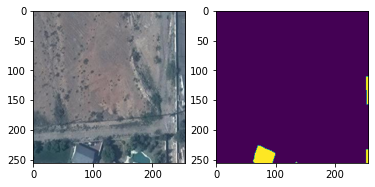

In [ ]:
batch = train_generator[0]
plt.subplot(1,2,1)
plt.imshow(batch[0][0].astype('int'))
plt.subplot(1,2,2)
plt.imshow(batch[1][0].astype('int').reshape(IMG_SIZE, IMG_SIZE));

# Model

In [ ]:
# define network parameters
activation = 'sigmoid' if CLASSES == 1 else 'softmax'

model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation, classes=CLASSES,
                encoder_freeze=True
                )


#для загрузки весов с диска
# model.load_weights(os.path.join(PATH_TO_CURRENT_MODEL, 
#                                 'model-02-0.256607.h5'))


model.compile(
    'Adam',
    loss=sm.losses.binary_crossentropy,
    metrics=[sm.metrics.iou_score],
)
# set_trainable(model)

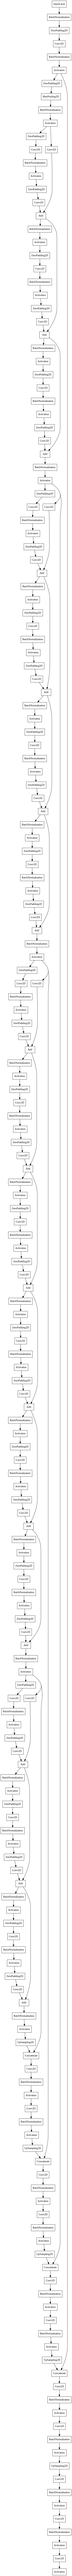

In [ ]:
activation = 'sigmoid' if CLASSES == 1 else 'softmax'
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation, classes=CLASSES,
                encoder_freeze=True
                )
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

# Train

## Callbacks

In [ ]:
current_datetime = datetime.now().strftime("%d-%m-%Y_%H:%M:%S")
weight_path=os.path.join(PATH_TO_CURRENT_MODEL, current_datetime,
                         "model-{epoch:02d}-{val_iou_score:02f}.h5")
checkpoint = ModelCheckpoint(weight_path, monitor='val_iou_score', verbose=1, 
                             save_best_only=True, mode='max')

early = EarlyStopping(monitor="val_iou_score", 
                      mode="max", 
                      patience=5)

log_dir = os.path.join(PATH_TO_CURRENT_MODEL, current_datetime, "logs")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# ниже с помощью магии создается коллбэк для вывода картинок в конце каждой эпохи
sample_image, sample_mask = valid_generator[0][0][0], valid_generator[0][1][0]
file_writer = tf.summary.create_file_writer(log_dir)
def display(display_list, return_fig=True, fig_size=(10,5)):
    figure = plt.figure(figsize=fig_size)

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    
    if return_fig:
        return figure
    else:
        plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]
def show_predictions(epoch):
    def plot_to_image(figure):
        """Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call."""
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        # Closing the figure prevents it from being displayed directly inside
        # the notebook.
        # plt.close(figure)
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # Add the batch dimension
        image = tf.expand_dims(image, 0)
        return image
    
    images = [sample_image.astype(int),
              sample_mask.reshape(sample_image.shape[:2]),
              model.predict(sample_image[tf.newaxis, ...])[0].reshape(sample_image.shape[:2])]
    figure =  display(images)
    with file_writer.as_default():
        tf.summary.image("Training data",plot_to_image(figure), step=epoch)
    plt.show()
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch and epoch%100 == 0:
            clear_output(wait=True)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
        show_predictions(epoch)

        

callbacks_list = [checkpoint, 
                  early, 
                  tensorboard_callback, 
                  DisplayCallback()]

## Tensorboard

In [ ]:
%reload_ext tensorboard

In [ ]:
# !kill 671
%tensorboard --logdir $log_dir

## Fit

Epoch 1/10
312/312 [==============================] - 342s 1s/step - loss: 0.3491 - iou_score: 0.4326 - val_loss: 0.3790 - val_iou_score: 0.4360

Epoch 00001: val_iou_score improved from -inf to 0.43600, saving model to /content/drive/MyDrive/my_ml_projects/unet+resnet34/10-04-2021_17:52:42/model-01-0.435999.h5

Sample Prediction after epoch 1



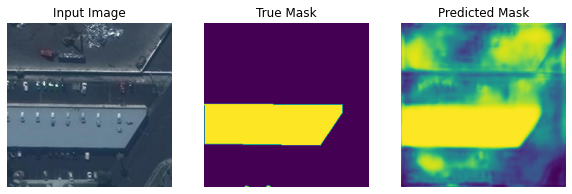

Epoch 2/10
312/312 [==============================] - 335s 1s/step - loss: 0.1580 - iou_score: 0.6562 - val_loss: 0.1537 - val_iou_score: 0.6870

Epoch 00002: val_iou_score improved from 0.43600 to 0.68699, saving model to /content/drive/MyDrive/my_ml_projects/unet+resnet34/10-04-2021_17:52:42/model-02-0.686995.h5

Sample Prediction after epoch 2



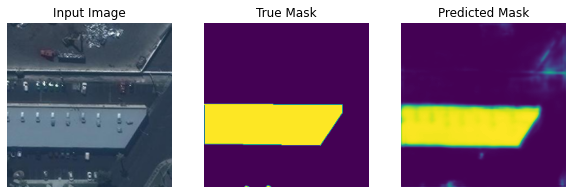

Epoch 3/10
312/312 [==============================] - 333s 1s/step - loss: 0.1391 - iou_score: 0.6893 - val_loss: 0.1484 - val_iou_score: 0.6854

Epoch 00003: val_iou_score did not improve from 0.68699

Sample Prediction after epoch 3



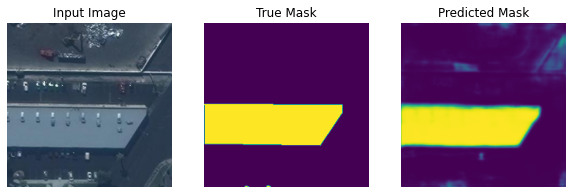

Epoch 4/10
312/312 [==============================] - 333s 1s/step - loss: 0.1258 - iou_score: 0.7159 - val_loss: 0.1416 - val_iou_score: 0.7182

Epoch 00004: val_iou_score improved from 0.68699 to 0.71820, saving model to /content/drive/MyDrive/my_ml_projects/unet+resnet34/10-04-2021_17:52:42/model-04-0.718197.h5

Sample Prediction after epoch 4



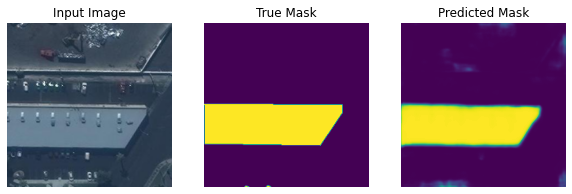

Epoch 5/10
312/312 [==============================] - 333s 1s/step - loss: 0.1177 - iou_score: 0.7322 - val_loss: 0.1339 - val_iou_score: 0.7287

Epoch 00005: val_iou_score improved from 0.71820 to 0.72874, saving model to /content/drive/MyDrive/my_ml_projects/unet+resnet34/10-04-2021_17:52:42/model-05-0.728742.h5

Sample Prediction after epoch 5



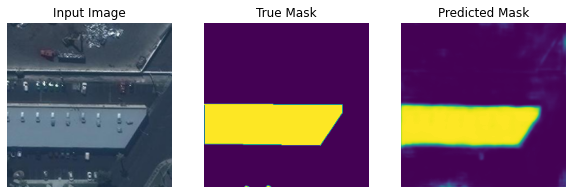

Epoch 6/10
312/312 [==============================] - 337s 1s/step - loss: 0.1101 - iou_score: 0.7475 - val_loss: 0.1345 - val_iou_score: 0.7200

Epoch 00006: val_iou_score did not improve from 0.72874

Sample Prediction after epoch 6



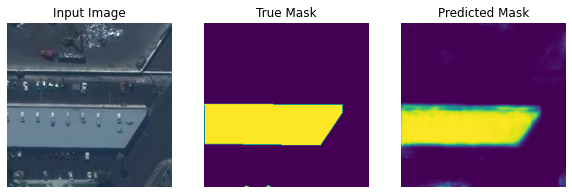

Epoch 7/10
312/312 [==============================] - 335s 1s/step - loss: 0.1029 - iou_score: 0.7581 - val_loss: 0.1417 - val_iou_score: 0.7506

Epoch 00007: val_iou_score improved from 0.72874 to 0.75058, saving model to /content/drive/MyDrive/my_ml_projects/unet+resnet34/10-04-2021_17:52:42/model-07-0.750581.h5

Sample Prediction after epoch 7



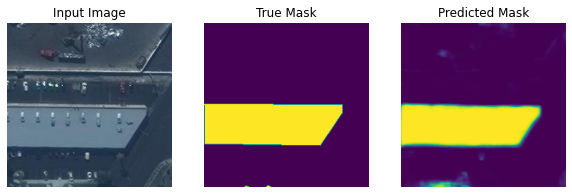

Epoch 8/10
312/312 [==============================] - 333s 1s/step - loss: 0.1011 - iou_score: 0.7611 - val_loss: 0.1330 - val_iou_score: 0.7479

Epoch 00008: val_iou_score did not improve from 0.75058

Sample Prediction after epoch 8



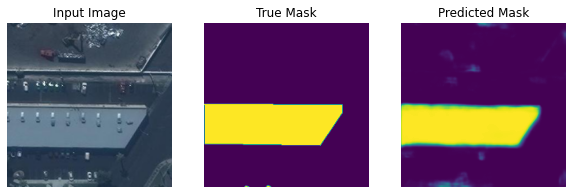

Epoch 9/10
312/312 [==============================] - 333s 1s/step - loss: 0.0963 - iou_score: 0.7727 - val_loss: 0.1302 - val_iou_score: 0.7494

Epoch 00009: val_iou_score did not improve from 0.75058

Sample Prediction after epoch 9



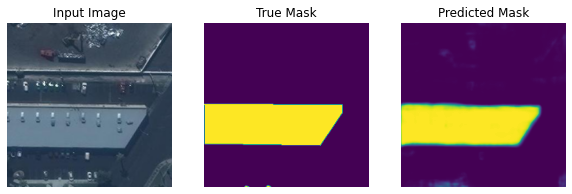

Epoch 10/10
312/312 [==============================] - 334s 1s/step - loss: 0.0919 - iou_score: 0.7783 - val_loss: 0.1260 - val_iou_score: 0.7458

Epoch 00010: val_iou_score did not improve from 0.75058

Sample Prediction after epoch 10



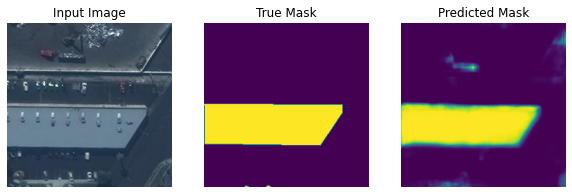

In [ ]:
history = model.fit(x=train_generator,
                    validation_data=valid_generator,
                    epochs=10,
                    callbacks=callbacks_list
                    )


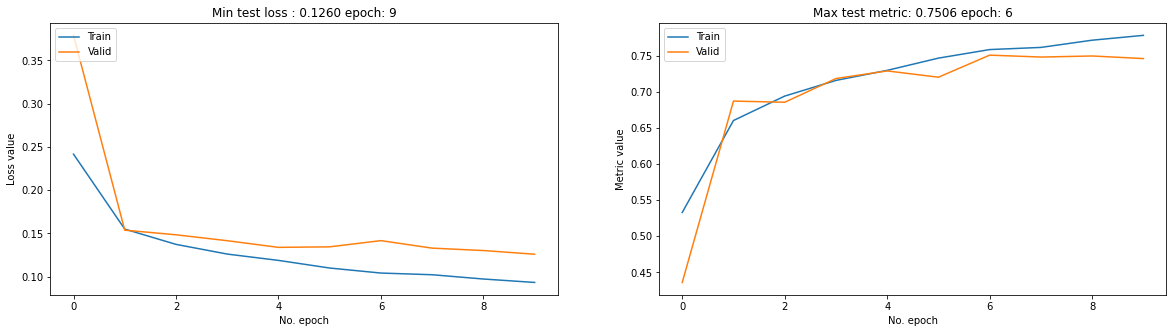

In [ ]:
#время рисовать графики
plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Valid')
min_loss_id = np.argmin(history.history['val_loss'])
plt.title('Min test loss : %.4f epoch: %s' % (history.history['val_loss'][min_loss_id], min_loss_id))
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")

plt.subplot(1, 2, 2)
plt.plot(history.history['iou_score'], label='Train')
plt.plot(history.history['val_iou_score'], label='Valid')
max_metric_id = np.argmax(history.history['val_iou_score'])
plt.title('Max test metric: %.4f epoch: %s' % (history.history['val_iou_score'][max_metric_id], max_metric_id))
plt.ylabel('Metric value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left");

# Inference

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/my_ml_projects/unet+resnet34/10-04-2021_17:52:42/model-07-0.750581.h5',
                                custom_objects={'iou_score': sm.metrics.iou_score})

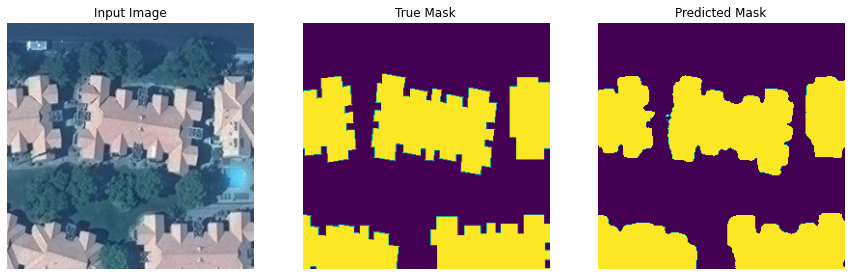

In [ ]:
sample_image, sample_mask = valid_generator[1][0][0], valid_generator[1][1][0]
pred_mask = model.predict(sample_image[np.newaxis,...]).reshape(sample_image.shape[:2]) > 0.5
display([sample_image.astype(int), 
         sample_mask.reshape(sample_image.shape[:2]),
         pred_mask],
        return_fig=False,
        fig_size=(15,5))